In [2]:
import yfinance as yf
import pandas as pd
import numpy as np

def get_price(tick,start='2020-10-01',end=None):
    return yf.Ticker(tick).history(start=start,end=end)['Close']

def get_prices(tickers,start='2020-10-01',end=None):
    df=pd.DataFrame()
    for s in tickers:
        df[s]=get_price(s,start,end)
    return df

feature_stocks=['tsla','fb','twtr','amzn','nflx','gbtc','gdx','intc','dal','c']
predict_stock='msft'

# training set
start_date_train='2020-10-01'
end_date_train='2020-12-31'

X_train=get_prices(feature_stocks,start=start_date_train,end=end_date_train)
y_train=get_prices([predict_stock],start=start_date_train,end=end_date_train)

# testing set
start_date_test='2021-01-01' # end date omit, default is doday
X_test=get_prices(feature_stocks,start=start_date_test)
y_test=get_prices([predict_stock],start=start_date_test)

X_train=np.array(X_train)
Y_train=np.array(y_train)
X_test=np.array(X_test)
Y_test=np.array(y_test)


In [3]:
len(X_train)

63

In [81]:
#linear regression
X_train_lin = np.concatenate( [X_train, np.ones((X_train.shape[0],1))],1)
X_test_lin = np.concatenate( [X_test, np.ones((X_test.shape[0],1))],1)

w = np.linalg.inv(X_train_lin.T @ X_train_lin) @ X_train_lin.T @ y_train

linear_train = X_train_lin @ w
linear_test = X_test_lin @ w

In [82]:
#SKR
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

dummyFeatureX_train = np.array(pd.get_dummies(X_train[0]))
dummyFeatureX_test = np.array(pd.get_dummies(X_test[0]))
ytrain = np.ravel(y_train,)
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
regr.fit(X_train, ytrain)

skr_train = regr.predict(X_train)
skr_test = regr.predict(X_test) # uses model to make predictions

In [83]:
# 1: Estimate the MSFT stock price with a fully connected neural network with 5 hidden layers. 
# Each hidden layer has 20 neurons. Use ReLU as the activation function.

import torch
import torch.nn as nn

x_train = torch.from_numpy(X_train).type(torch.Tensor)
x_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(Y_train).type(torch.Tensor)
y_test = torch.from_numpy(Y_test).type(torch.Tensor)

N, D_in, H, D_out = 64, len(X_train[0]), 20, len(Y_train[0])
device = torch.device('cpu')

#x = torch.randn(N, D_in, device=device)
#y = torch.randn(N, D_out, device=device)


model = torch.nn.Sequential(
            torch.nn.Linear(D_in, H),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            torch.nn.Linear(H, D_out),).to(device)

loss_fn = torch.nn.MSELoss(reduction='mean')

learning_rate = 5e-8

lossEpoch = []

for t in range(500):
    y_pred = model(x_train)
    loss = loss_fn(y_pred, y_train)
    
    lossEpoch.append([t, loss.item()])
    #print(t, loss.item())
    
    model.zero_grad()
    
    loss.backward()
    
    with torch.no_grad():
        for param in model.parameters():
            param.data -= learning_rate * param.grad

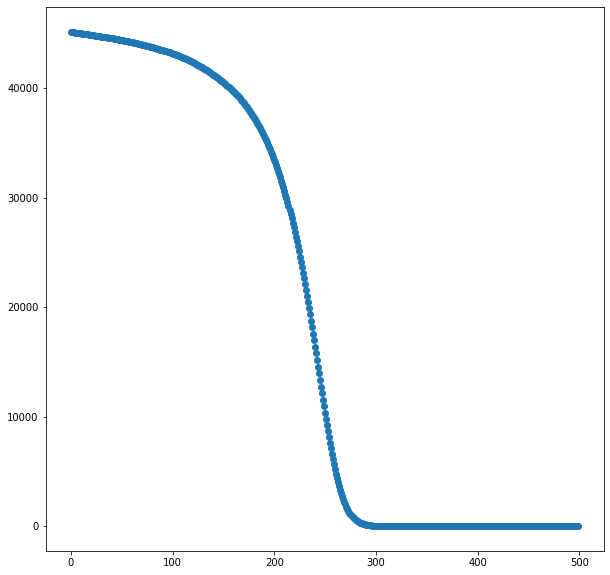

In [92]:
#2: plot loss vs epoch
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))
loss_epoch_array = np.array(lossEpoch)
#print(loss_epoch_array[:,0])
x_epoch = loss_epoch_array[:,0]
y_loss = loss_epoch_array[:,1]
plt.scatter(x_epoch,y_loss)

In [85]:
#3: repeat 1 with drop out and graph
model_drop = torch.nn.Sequential(
            torch.nn.Linear(D_in, H),
            #torch.nn.ReLU(),
            torch.nn.Dropout(.01),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H),
            torch.nn.Dropout(.01),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H),
            torch.nn.Dropout(.01),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H),
            torch.nn.Dropout(.01),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H),
            torch.nn.Dropout(.01),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H),
            torch.nn.Dropout(.01),
            torch.nn.ReLU(),
            torch.nn.Linear(H, D_out),).to(device)

lossEpochDrop = []

for t in range(600):
    y_pred_drop = model_drop(x_train)
    loss_drop = loss_fn(y_pred_drop, y_train)
    
    lossEpochDrop.append([t, loss_drop.item()])
    #print(t, loss_drop.item())
    
    model_drop.zero_grad()
    
    loss_drop.backward()
    
    with torch.no_grad():
        for param in model_drop.parameters():
            param.data -= learning_rate * param.grad

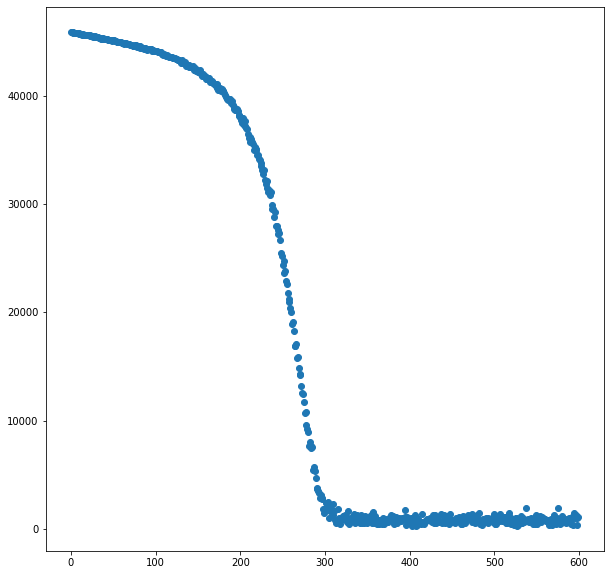

In [93]:
plt.figure(figsize=(10,10))
drop_loss_epoch_array = np.array(lossEpochDrop)
x_epoch_drop = drop_loss_epoch_array[:,0]
y_loss_drop = drop_loss_epoch_array[:,1]
plt.scatter(x_epoch_drop,y_loss_drop)

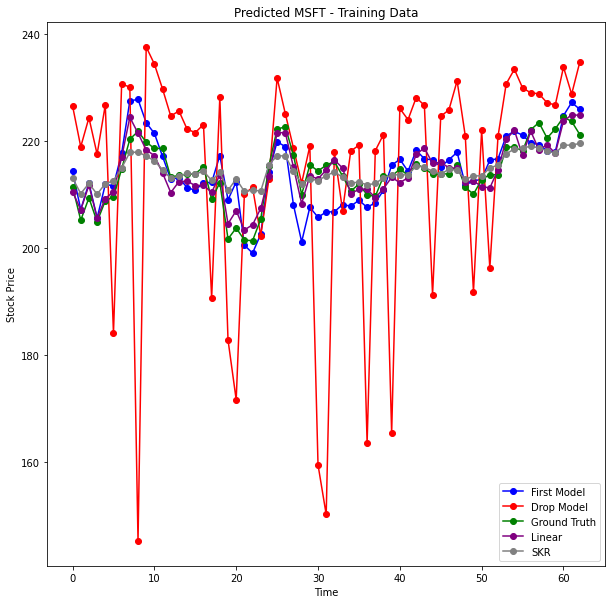

In [100]:
#4: lot the predicted MSFT price (with and without dropout) for the training data. 
#Include ground truth and SVR and linear regression from earlier HW

first_model = model(x_train).detach().numpy()
drop_model = model_drop(x_train).detach().numpy()

time = range(63)

plt.figure(figsize=(10,10))

ax = plt.gca()
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Predicted MSFT - Training Data")

ax.plot(time, first_model, color = "b", label="First Model", marker='o')
ax.plot(time, drop_model, color = "r", label = "Drop Model", marker='o')
ax.plot(time, y_train, color = "g", label = "Ground Truth", marker='o')
ax.plot(time, linear_train, color = "purple", label = "Linear", marker='o')
ax.plot(time, skr_train, color = "grey", label = "SKR", marker='o')
ax.legend()

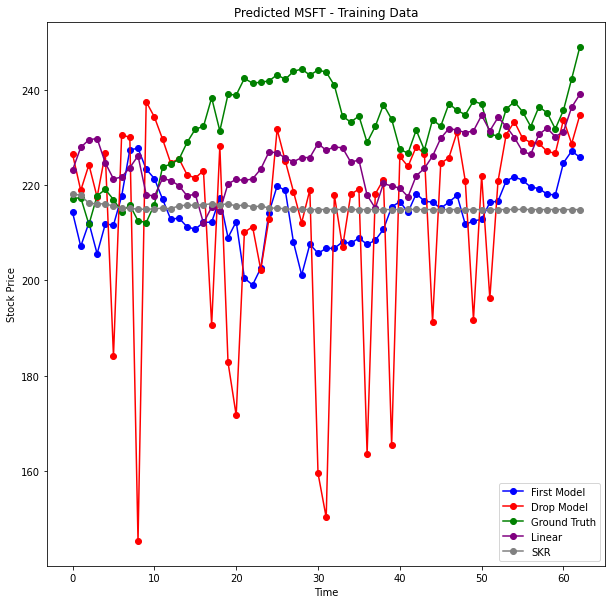

In [101]:
#5: Repeat plot from 4 with testing data
first_model_test = model(x_test).detach().numpy()
drop_model_test = model_drop(x_test).detach().numpy()

plt.figure(figsize=(10,10))

ax = plt.gca()
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Predicted MSFT - Training Data")

ax.plot(time, first_model, color = "b", label="First Model", marker='o')
ax.plot(time, drop_model, color = "r", label = "Drop Model", marker='o')
ax.plot(time, y_test, color = "g", label = "Ground Truth", marker='o')
ax.plot(time, linear_test, color = "purple", label = "Linear", marker='o')
ax.plot(time, skr_test, color = "grey", label = "SKR", marker='o')
ax.legend()